In [1]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from obspy import read_inventory
import pygmt
import shutil
import json
from tqdm import tqdm
import re
from pyFMST import fmst, fmstUtils

/home/wp280/miniconda3/envs/penv/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
grids = {}
gridc = {}
backv = {}
covar = {}

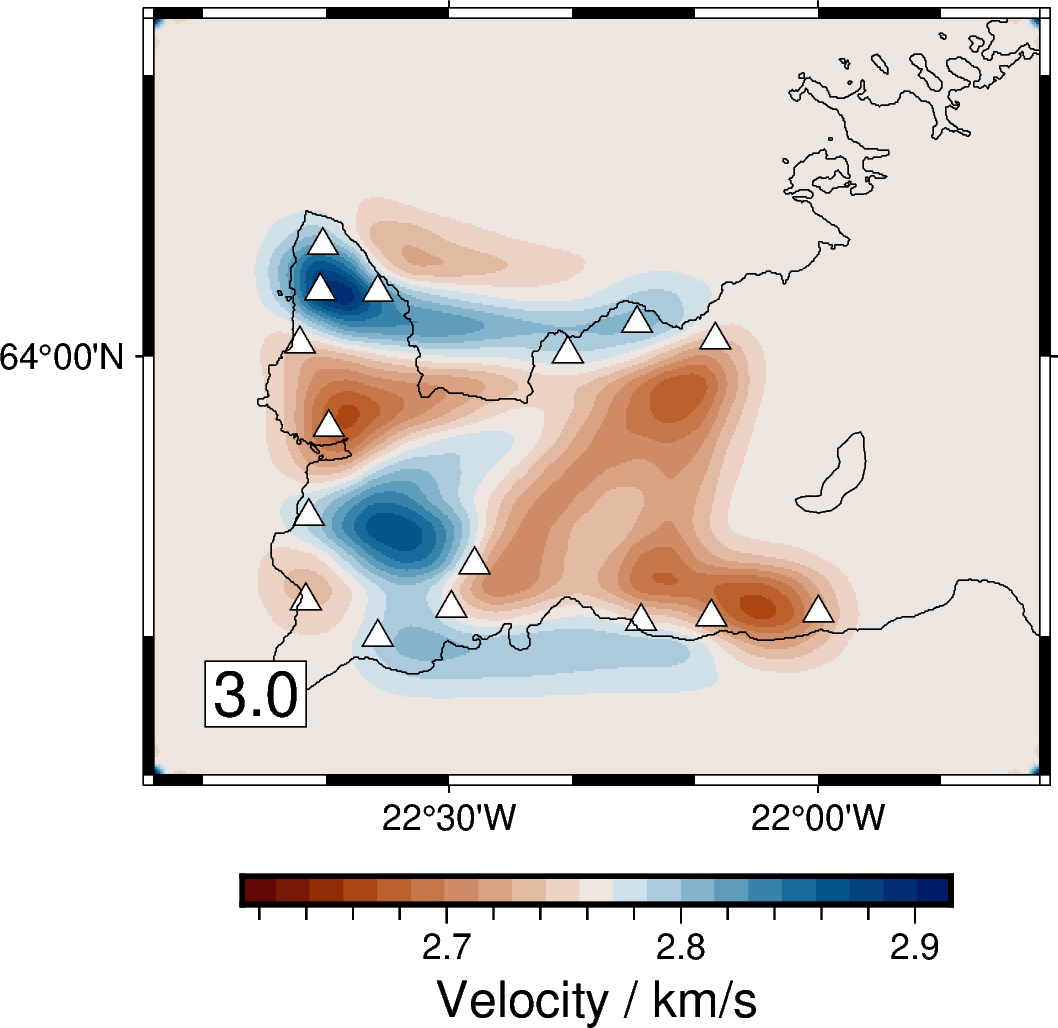

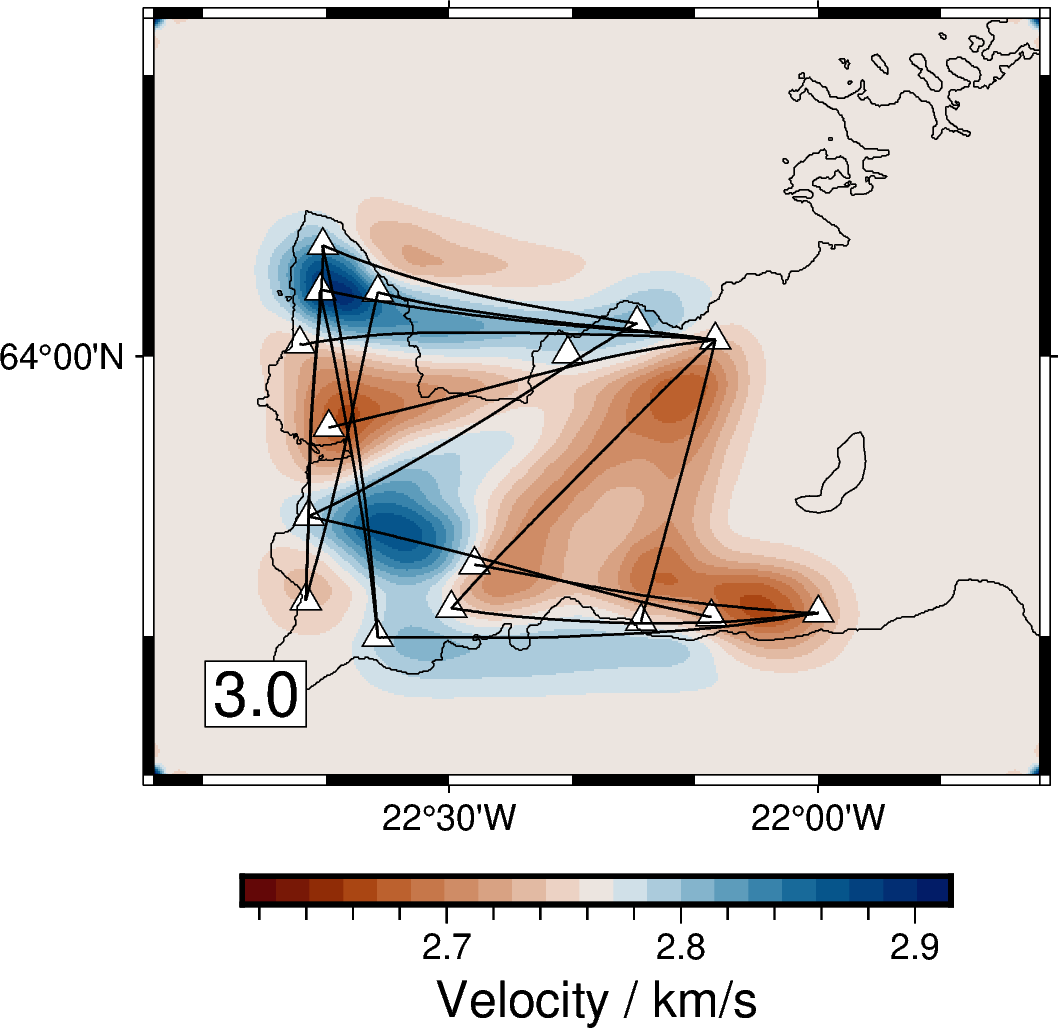

        0        1
0  183.67  0.03584
1   99.92  0.01061
2   99.89  0.01060
3   97.14  0.01003
4   97.33  0.01007
5   96.94  0.00998
6   96.94  0.00999


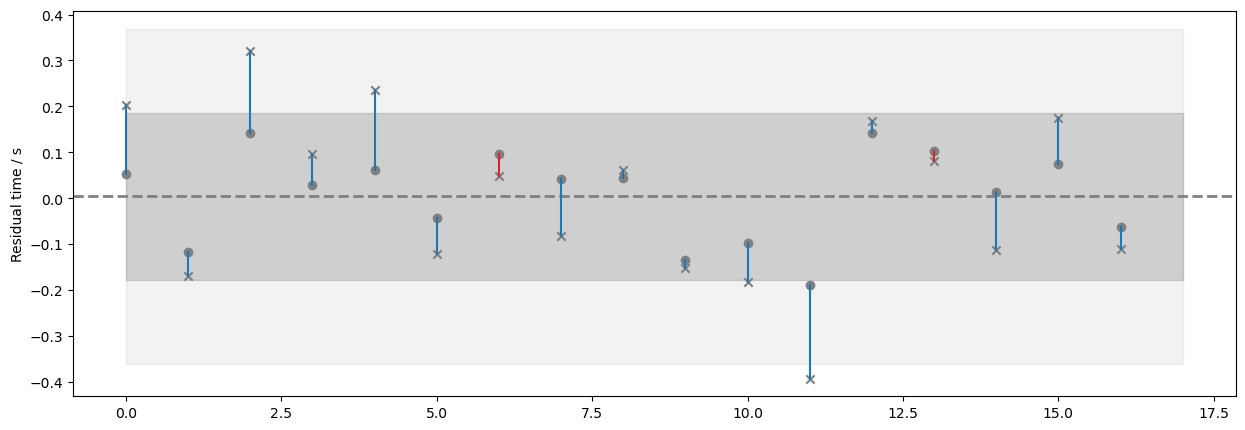

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.42s/it]


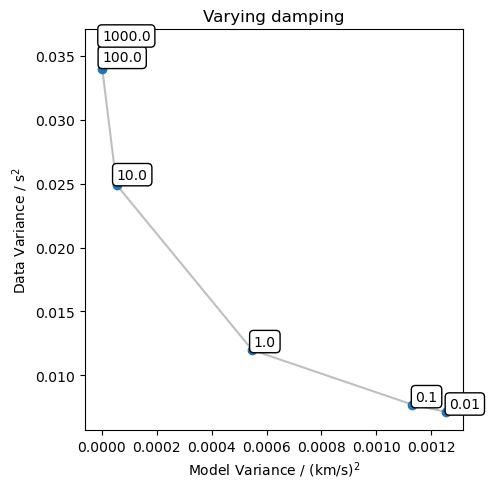

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.41s/it]


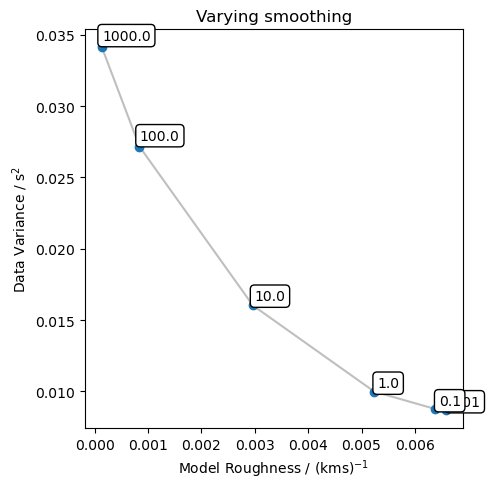

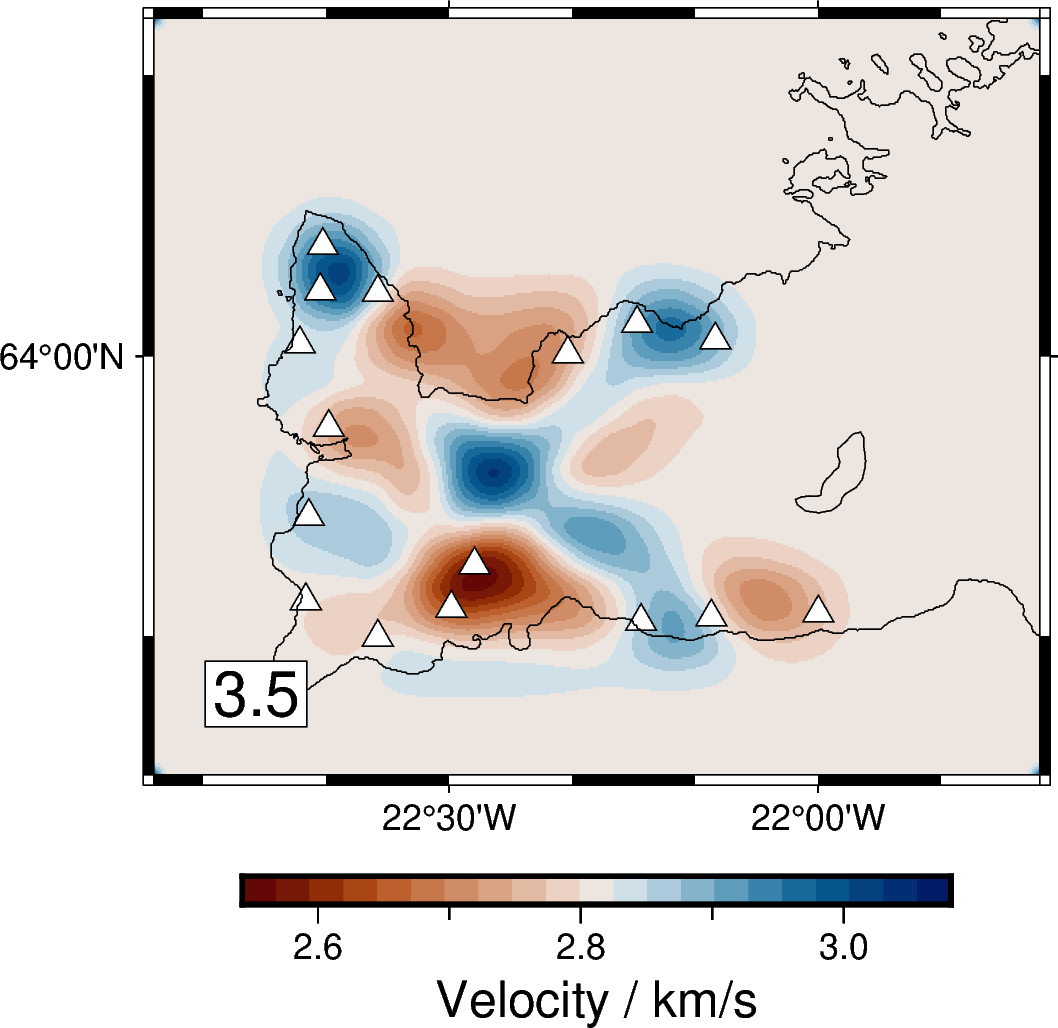

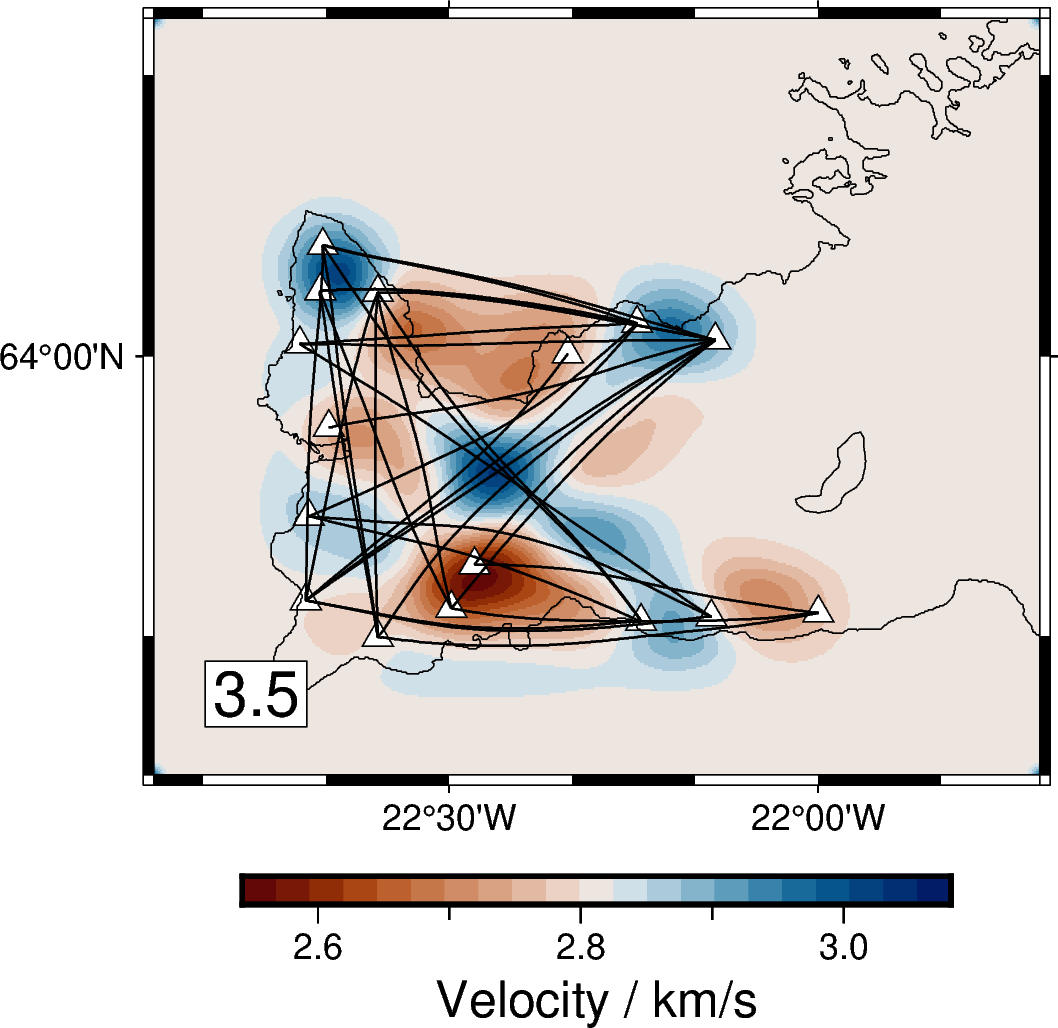

        0        1
0  230.05  0.05463
1  131.58  0.01787
2  124.53  0.01601
3  120.95  0.01510
4  120.20  0.01491
5  118.99  0.01461
6  118.73  0.01455


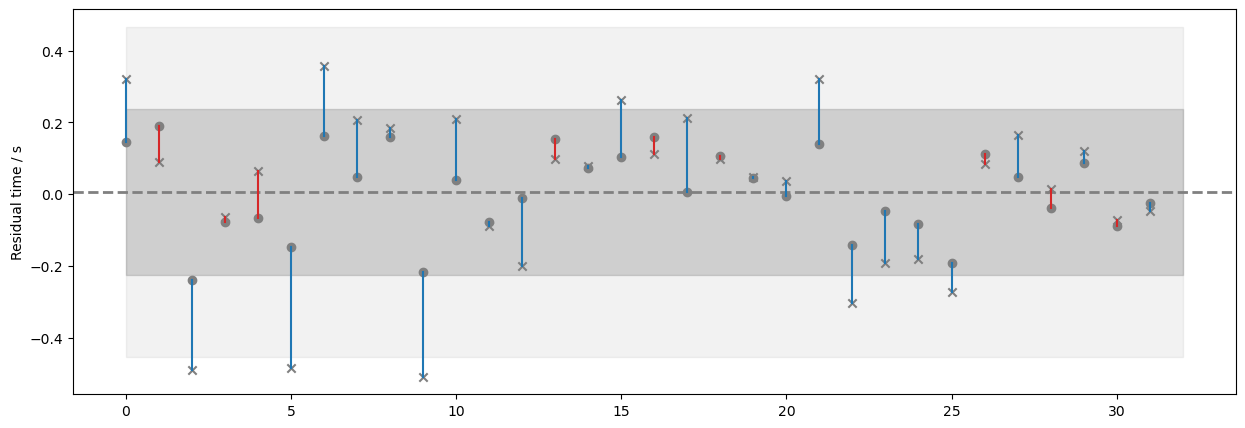

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.48s/it]


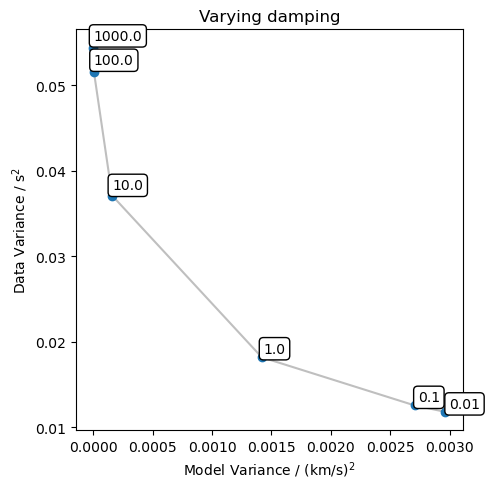

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.40s/it]


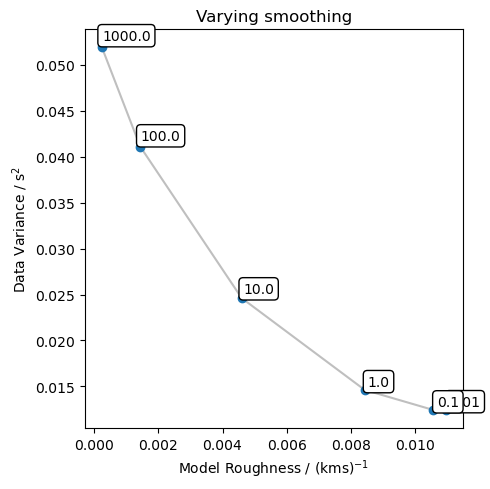

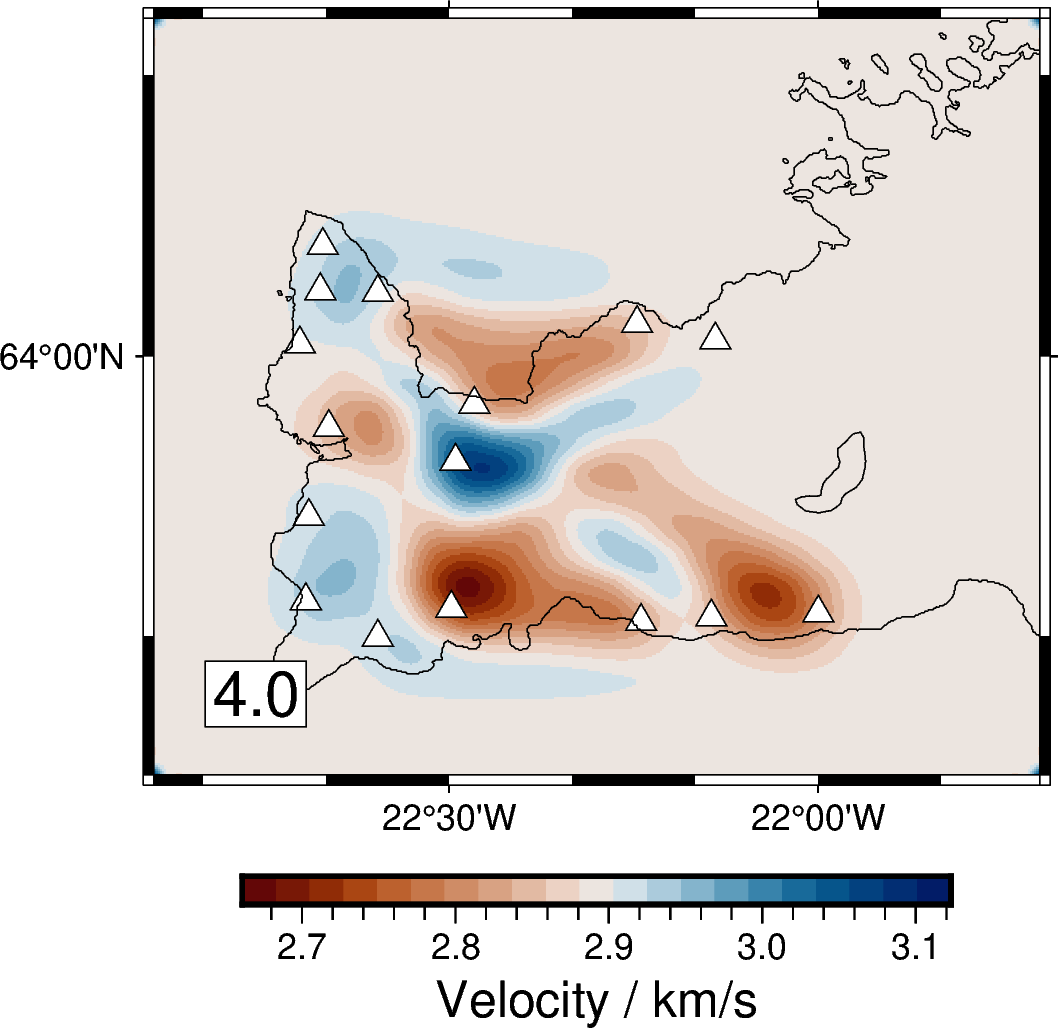

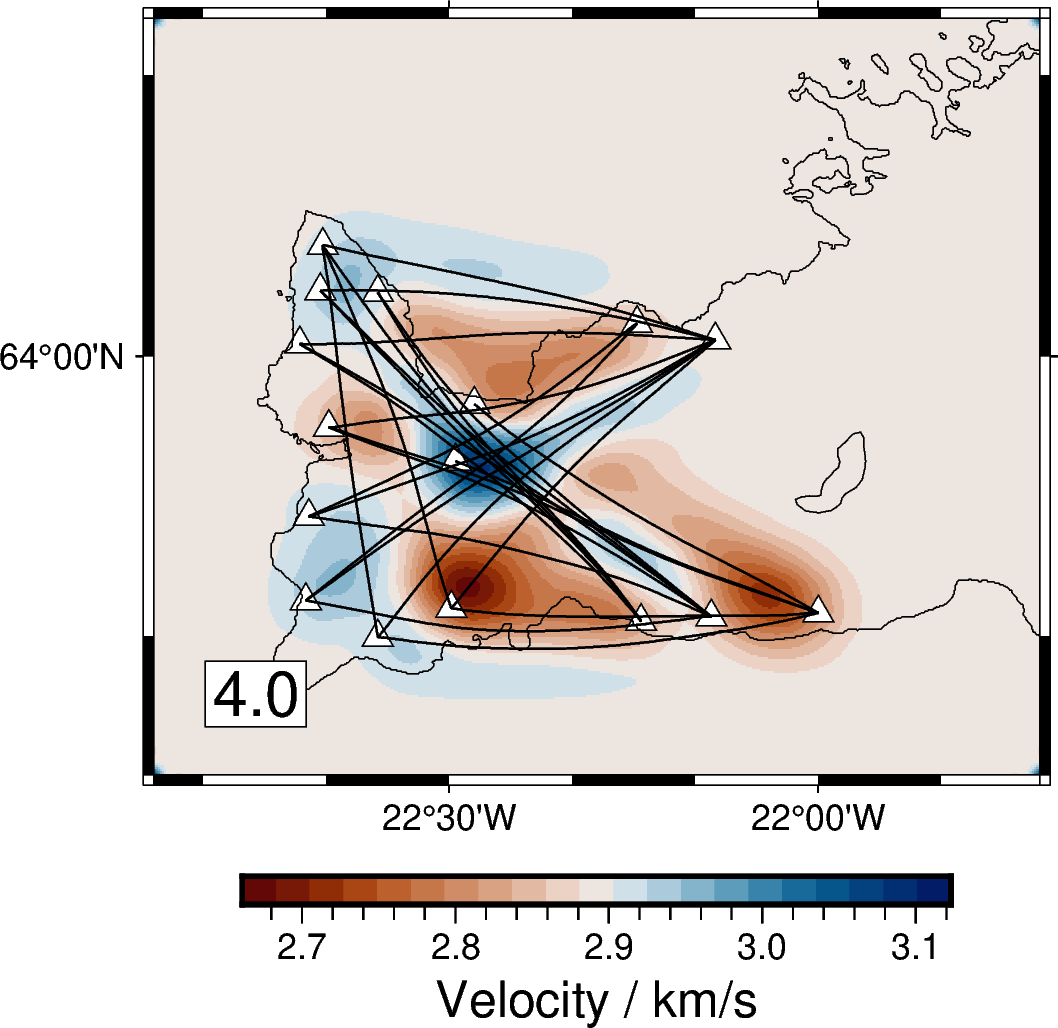

        0        1
0  224.38  0.05228
1  132.87  0.01833
2  130.01  0.01755
3  123.26  0.01578
4  123.96  0.01596
5  122.69  0.01563
6  122.87  0.01568


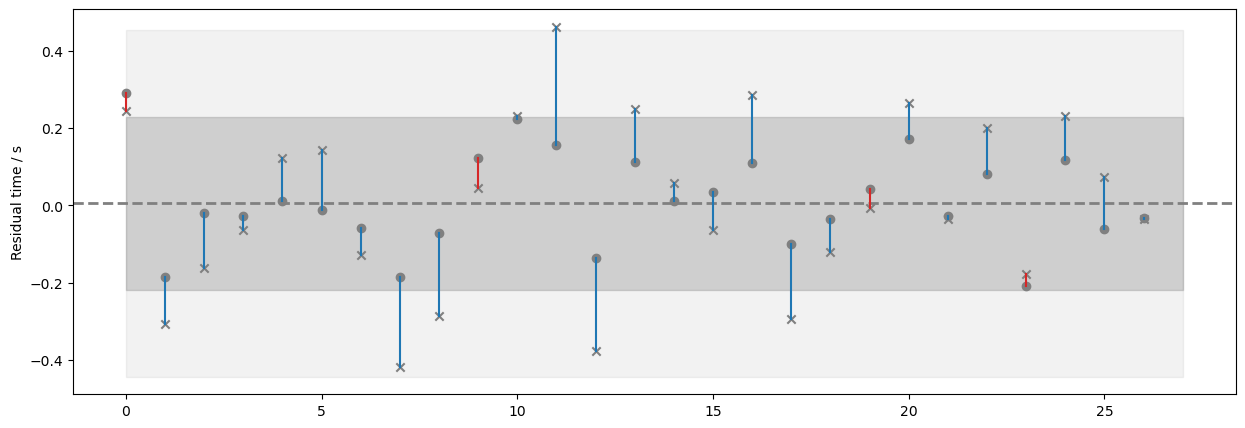

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.45s/it]


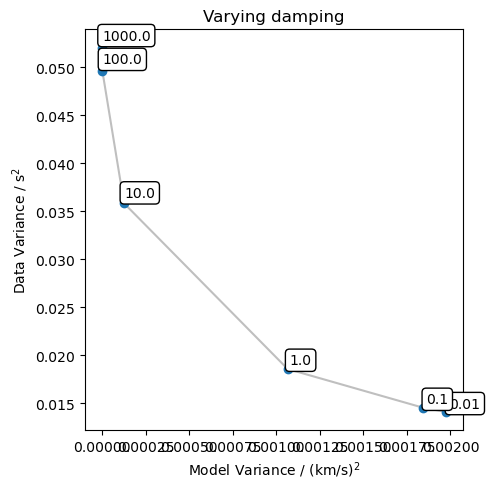

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.40s/it]


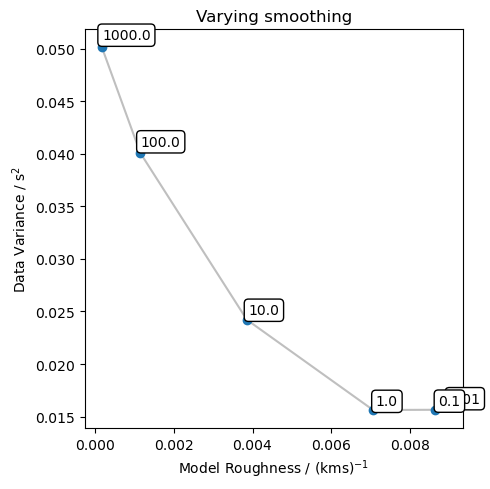

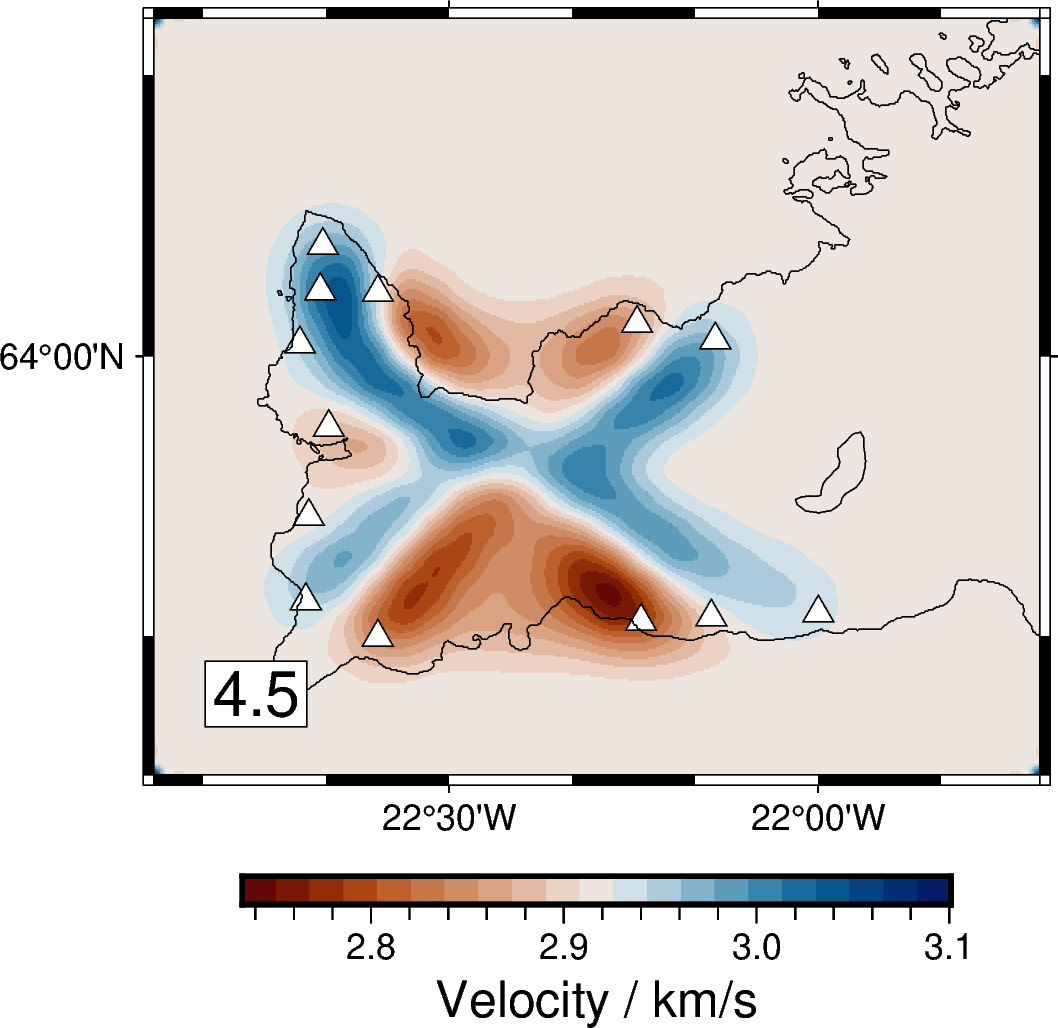

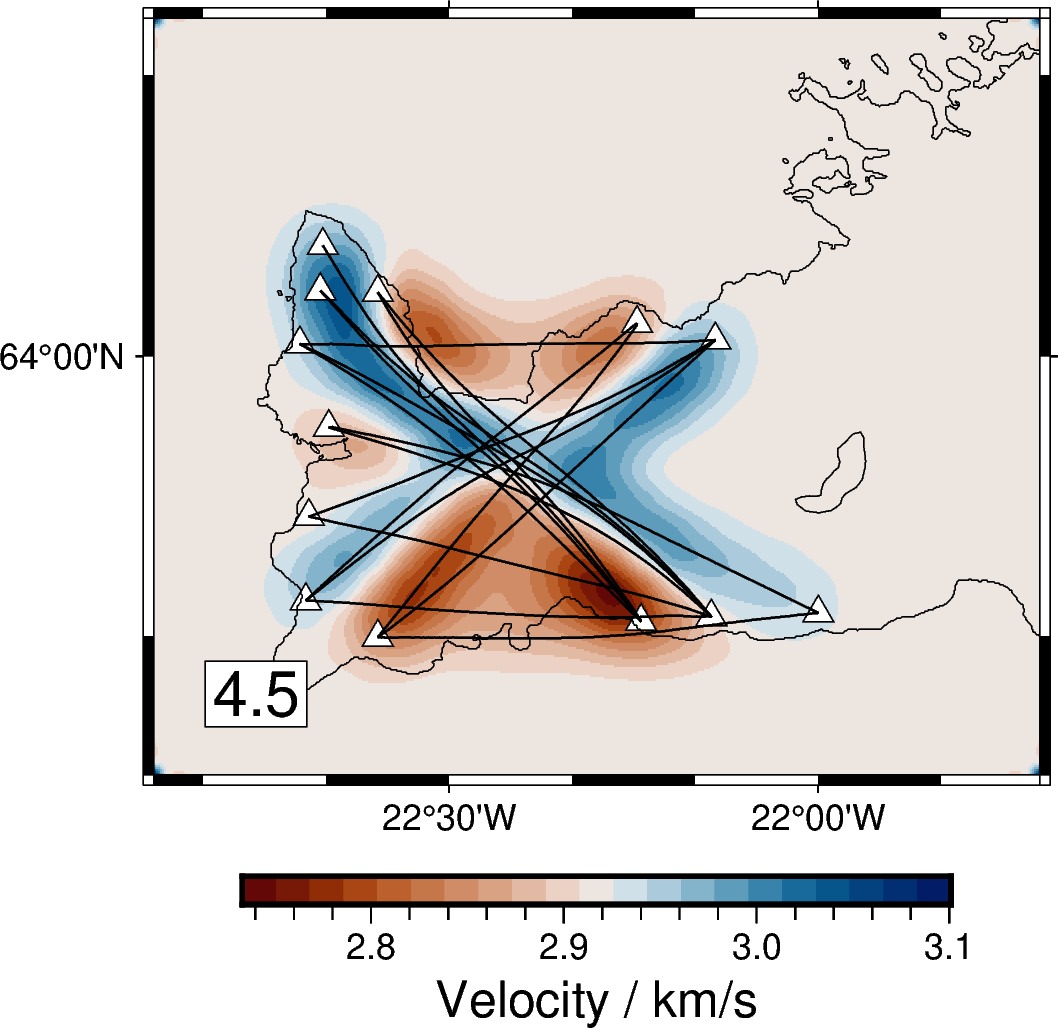

        0        1
0  229.11  0.05558
1  117.27  0.01456
2  105.27  0.01173
3   99.51  0.01049
4   99.30  0.01044
5   97.76  0.01012
6   97.76  0.01012


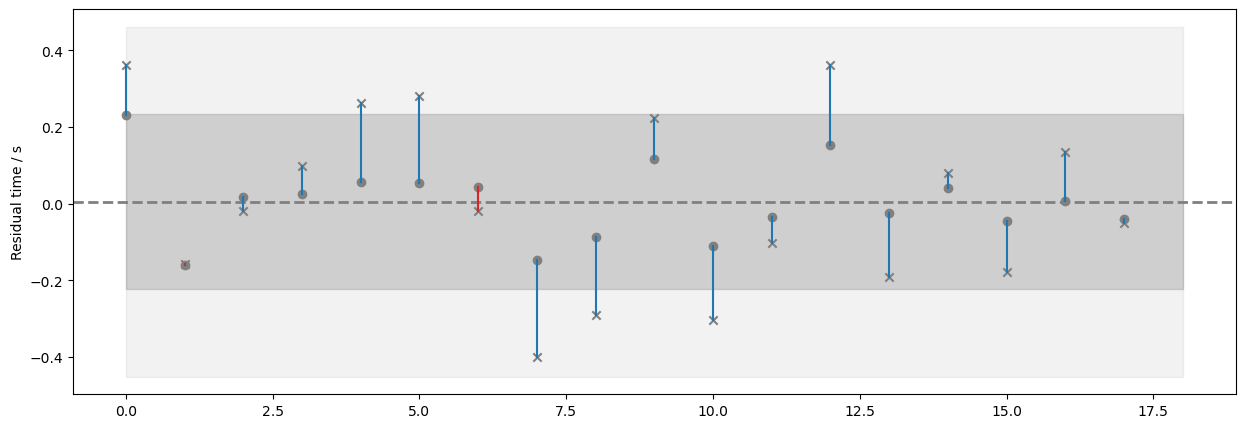

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.80s/it]


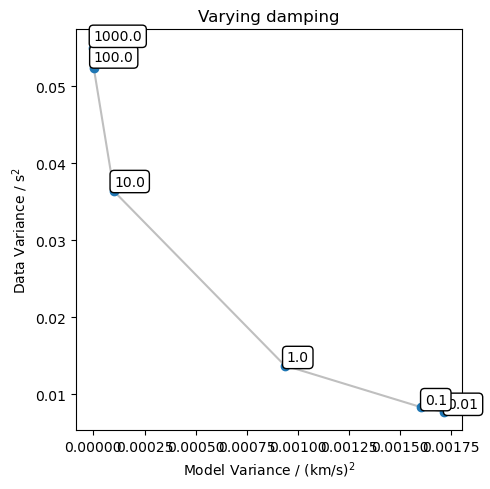

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.83s/it]


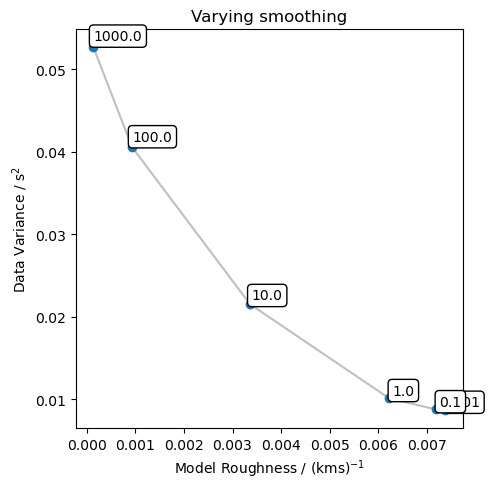

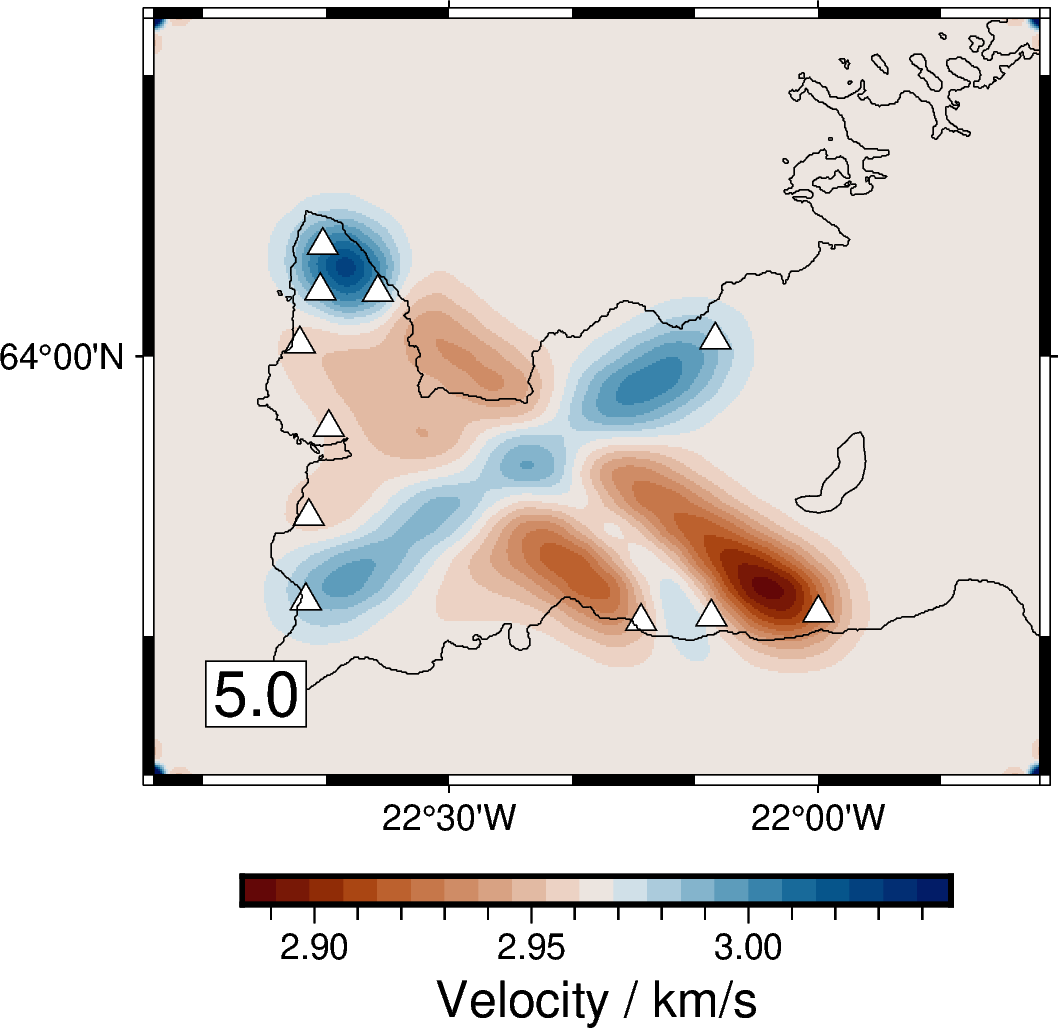

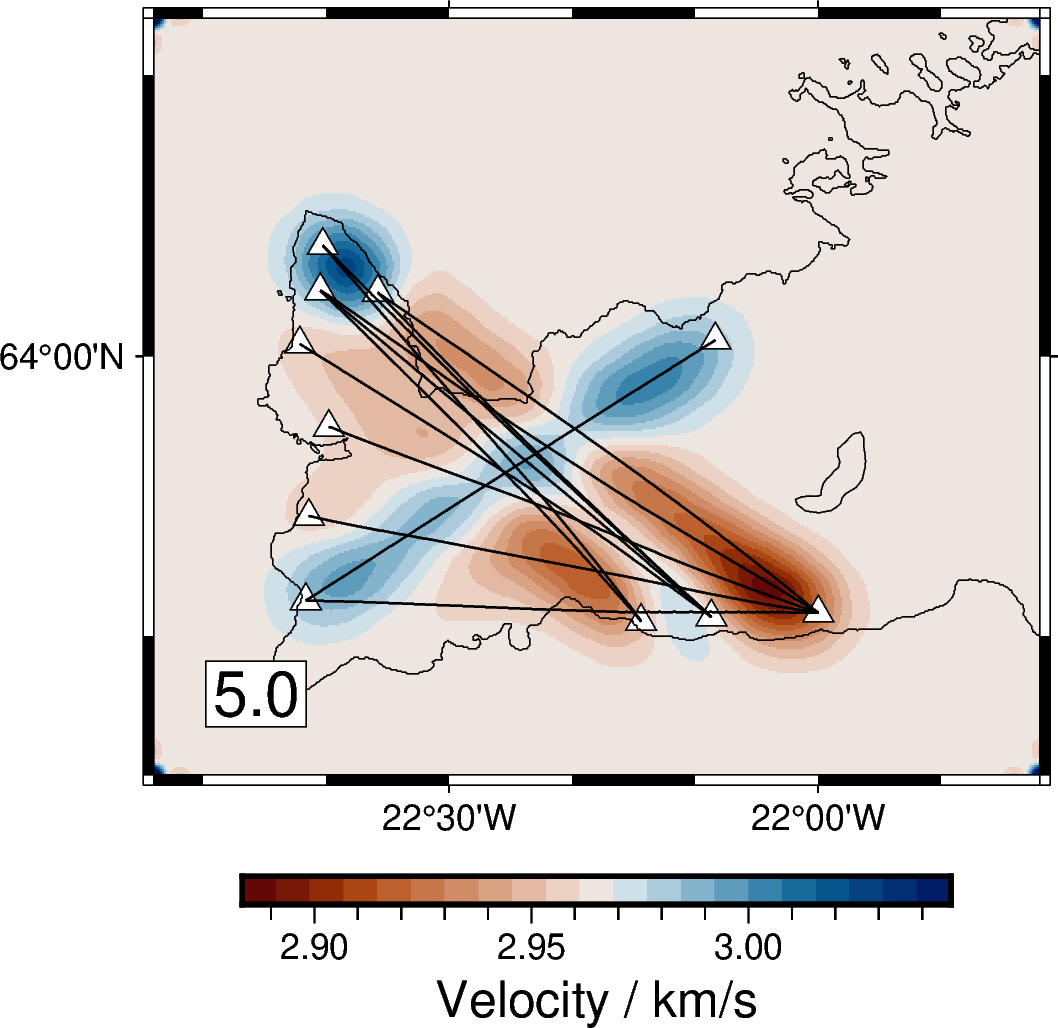

        0        1
0  116.56  0.01482
1   65.42  0.00467
2   65.88  0.00473
3   64.12  0.00449
4   63.98  0.00447
5   63.66  0.00442
6   63.61  0.00441


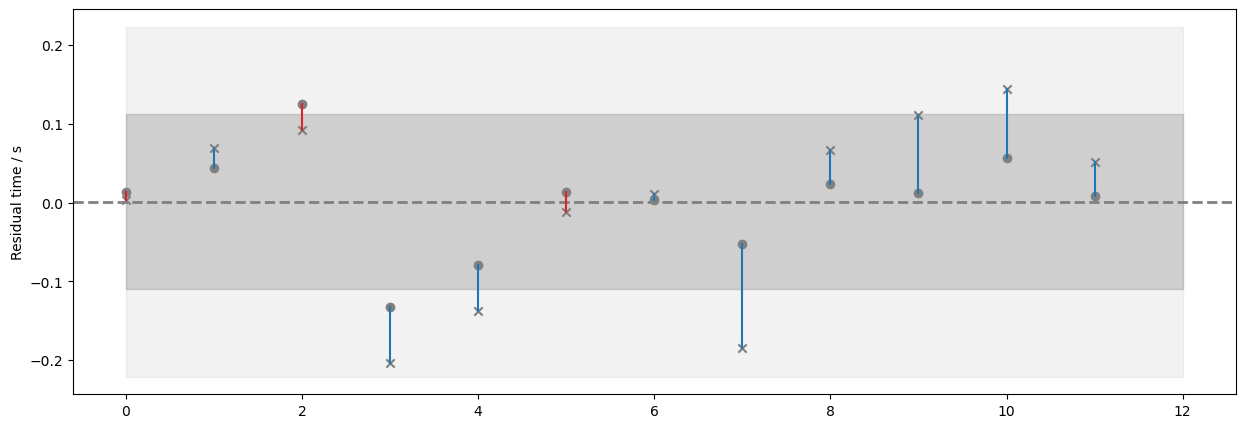

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.39s/it]


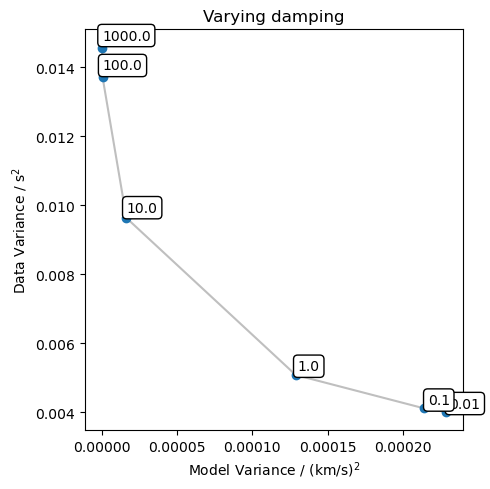

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.40s/it]


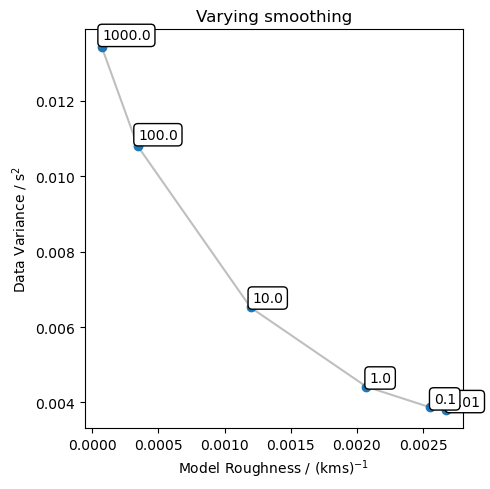

In [3]:
lat_num = 27
lon_num = 31

freqs=[3.0,3.5,4.0,4.5,5.0]

for freq in freqs:
    # print("Running for period",freq)
    doggy = fmst(path="/raid2/wp280/PhD/reykjanes/nodes/msnoise-test/FMST", templates="/raid2/wp280/PhD/reykjanes/nodes/msnoise-test/FMST/templates")
    
    doggy.load_velocity_pairs("/raid2/wp280/PhD/reykjanes/nodes/msnoise-test/REGIONAL/auto_picks_snr_5_phase_ZZ_new.json", freq)
    doggy.set_region(region=[64.2, 63.75, -22.9, -21.7])
    
    doggy.load_stations('/raid2/wp280/PhD/reykjanes/nodes/dataless/xml/smartsolo_response.xml')
    doggy.read_station_pairs("/raid2/wp280/PhD/reykjanes/nodes/msnoise-test/csvs/all_stations_pairs.csv", drop=True)
    
    doggy.refine_station_pairs(method='std', arg=2.0)
    
    doggy.set_background_vel(np.average(doggy.station_pairs_complete['vel'], weights=doggy.station_pairs_complete['gcm']))
    
    doggy.config_grid(latgrid=lat_num, longrid=lon_num)
    doggy.create_grid()
    doggy.create_sources()

    # Lower uncertainty to maximise difference in the covariance matrix

    if False:

        doggy.create_otimes(unc=0.001)
        doggy.config_ttomoss(init=True, subinvss={'damping':1.0, 'smoothing':0.0})
        
        doggy.run_ttomoss()
        doggy.run_tslicess(True)
        doggy.load_result_grid()
    
        subprocess.run('covary', cwd=doggy.path)
    
        if os.path.exists(os.path.join(doggy.path, "covary.out")):
            with open(os.path.join(doggy.path, "covary.out"), "r") as file:
                cov = [float(line.strip()) for line in file.readlines()[1:]]
    
        covar[freq] = cov

    # Normal inversion with optimal damping and smoothing

    doggy.create_otimes(unc=0.1)
    doggy.config_ttomoss(init=True, subinvss={'damping':1.0, 'smoothing':1.0})
    
    doggy.run_ttomoss()
    doggy.run_tslicess(True)
    doggy.load_result_grid()

    doggy.plot_map(nlevels = 21, projection='M7.5c', plot_stations=True,plot_caption=str(freq))
    doggy.plot_map(nlevels = 21, projection='M7.5c', plot_stations=True,plot_caption=str(freq),plot_rays=True)


    residuals = pd.read_csv("/raid2/wp280/PhD/reykjanes/nodes/msnoise-test/FMST/residuals.dat",sep=r" ",header=None)
    print(residuals)
    # break
    
    if os.path.exists(os.path.join(doggy.path, "gridc.vtx")):
        with open(os.path.join(doggy.path, "gridc.vtx"), "r") as file:
            vels = [float(line.strip()) for line in file.readlines()[3:]]

    grids[freq] = doggy.xyz_data
    gridc[freq] = vels
    backv[freq] = np.average(doggy.station_pairs_complete['vel'], weights=doggy.station_pairs_complete['gcm'])
    
    doggy.plot_vel_dots(use_model=True)

    # doggy.plot_hist(use_model=True,xlim=2)

    doggy.config_ttomoss(init=True, subinvss={'damping':3.0, 'smoothing':3.0})
    doggy.lcurve(sample_range=[0.01, 1000], points=6, iterations=5, factor="damping")
    doggy.config_ttomoss(init=True, subinvss={'damping':1.0, 'smoothing':3.0})
    doggy.lcurve(sample_range=[0.01, 1000], points=6, iterations=5, factor="smoothing")
    
    # doggy.config_ttomoss(init=True, subinvss={'damping':3.0, 'smoothing':3.0})
    # doggy.lcurve(sample_range=[0.1, 100], points=7, iterations=5, save=f'lcurves/{freq}_3d_smooth.pdf')

In [15]:
# velsm = {}
# velsa = {}
# for freq in tqdm(freqs):
#     print("Running for period",freq)
#     doggy = fmst(path="/raid2/wp280/intcc/pyFMST", templates="/raid2/wp280/intcc/pyFMST/templates")
    
#     doggy.load_velocity_pairs("/raid2/wp280/intcc/REGIONAL/auto_picks_snr_5_phase_ZZ.json", freq)
#     doggy.set_region(region=[64.2, 63.7, -22.9, -21.3])
#     doggy.load_stations('/raid2/wp280/intcc/inventory/xmlcombined/merged_response.xml')
#     doggy.read_station_pairs("/raid2/wp280/intcc/csvs/all_stations_pairs_20_24.csv", drop=True)
    
#     doggy.refine_station_pairs(method='std', arg=2.0)
#     velsm[freq] = np.mean(doggy.station_pairs_complete['vel'])
#     velsa[freq] = np.average(doggy.station_pairs_complete['vel'], weights=doggy.station_pairs_complete['gcm'])

[[3.0, 3.5, 4.0, 4.5, 5.0], [2.7640162045934695, 2.812349872725248, 2.891921678610911, 2.916611024849749, 2.9648860215083515]]


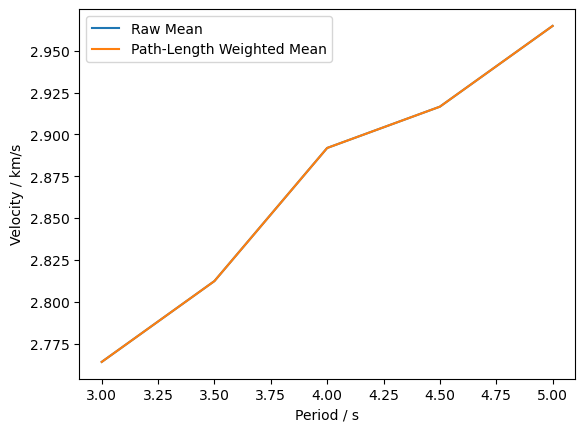

In [22]:
fig, ax= plt.subplots()

ax.plot(backv.keys(), backv.values(), label='Raw Mean')
ax.plot(backv.keys(), backv.values(), label='Path-Length Weighted Mean')

# Done station pair RY_HOPS_RY_THOR__TT_RR

print([list(backv.keys()), list(backv.values())])

ax.set_xlabel("Period / s")
ax.set_ylabel("Velocity / km/s")

ax.legend()

In [12]:
gridr = {}

print(grids.keys())
# freqs=[2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5]

for idx, item in enumerate(list(grids[freqs[0]])):
    key = str(list(item[0:2]))
    gridr[key] = {}

    for freq in freqs:
        gridr[key][freq] = list(grids[freq][idx])[-1]

dict_keys([2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0])


In [13]:
import pickle

with open('ntm/gridr.pickle', 'wb') as handle:
    pickle.dump(gridr, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ntm/gridc.pickle', 'wb') as handle:
    pickle.dump(gridc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ntm/backv.pickle', 'wb') as handle:
    pickle.dump(backv, handle, protocol=pickle.HIGHEST_PROTOCOL)

if False:

    with open('covar.pickle', 'wb') as handle:
        pickle.dump(covar, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
medians = {}
for period, grid in grids.items():
    median = np.median(grid[:][:-1])
    print(period, median)
    medians[period] = median.round(3)

2.0 2.67799997
2.25 2.6760001199999994
2.5 2.67400002
2.75 2.704999914822596
3.0 2.7330000390143208
3.25 2.7630000086449376
3.5 2.7980000975759456
3.75 2.8259999747407663
4.0 2.8499999
4.25 2.868999960000001
4.5 2.887000079999999
4.75 2.90799999
5.0 2.93400002
5.25 2.9530000699999994
5.5 2.9739999799999994
5.75 2.999000069935273
6.0 3.02099991
6.25 3.04399991
6.5 3.0639998900000003
6.75 3.08500004
7.0 3.0999999


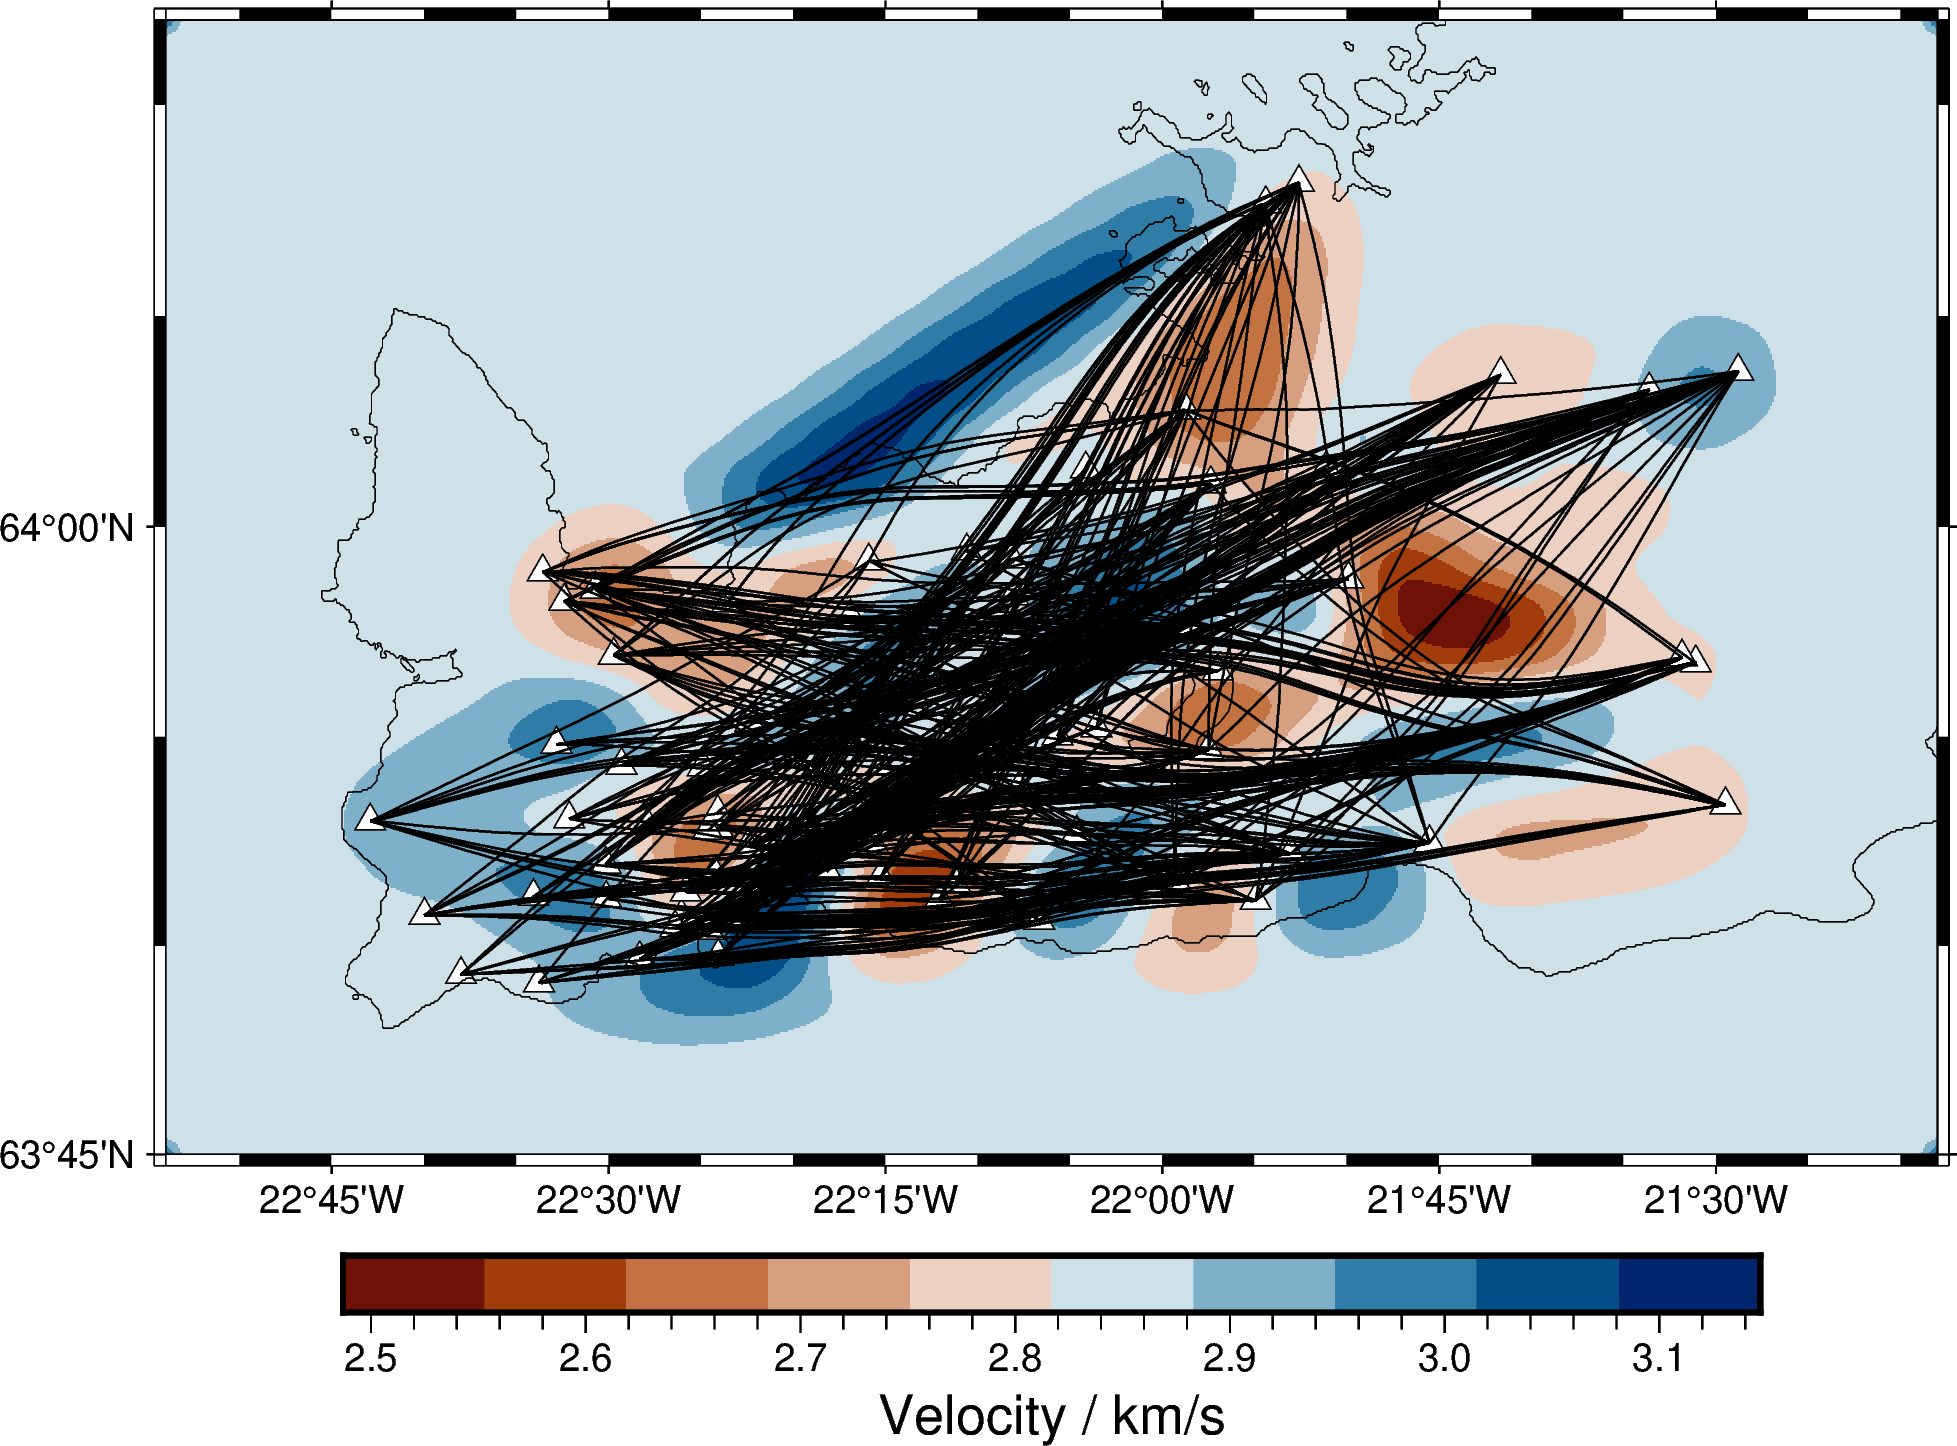

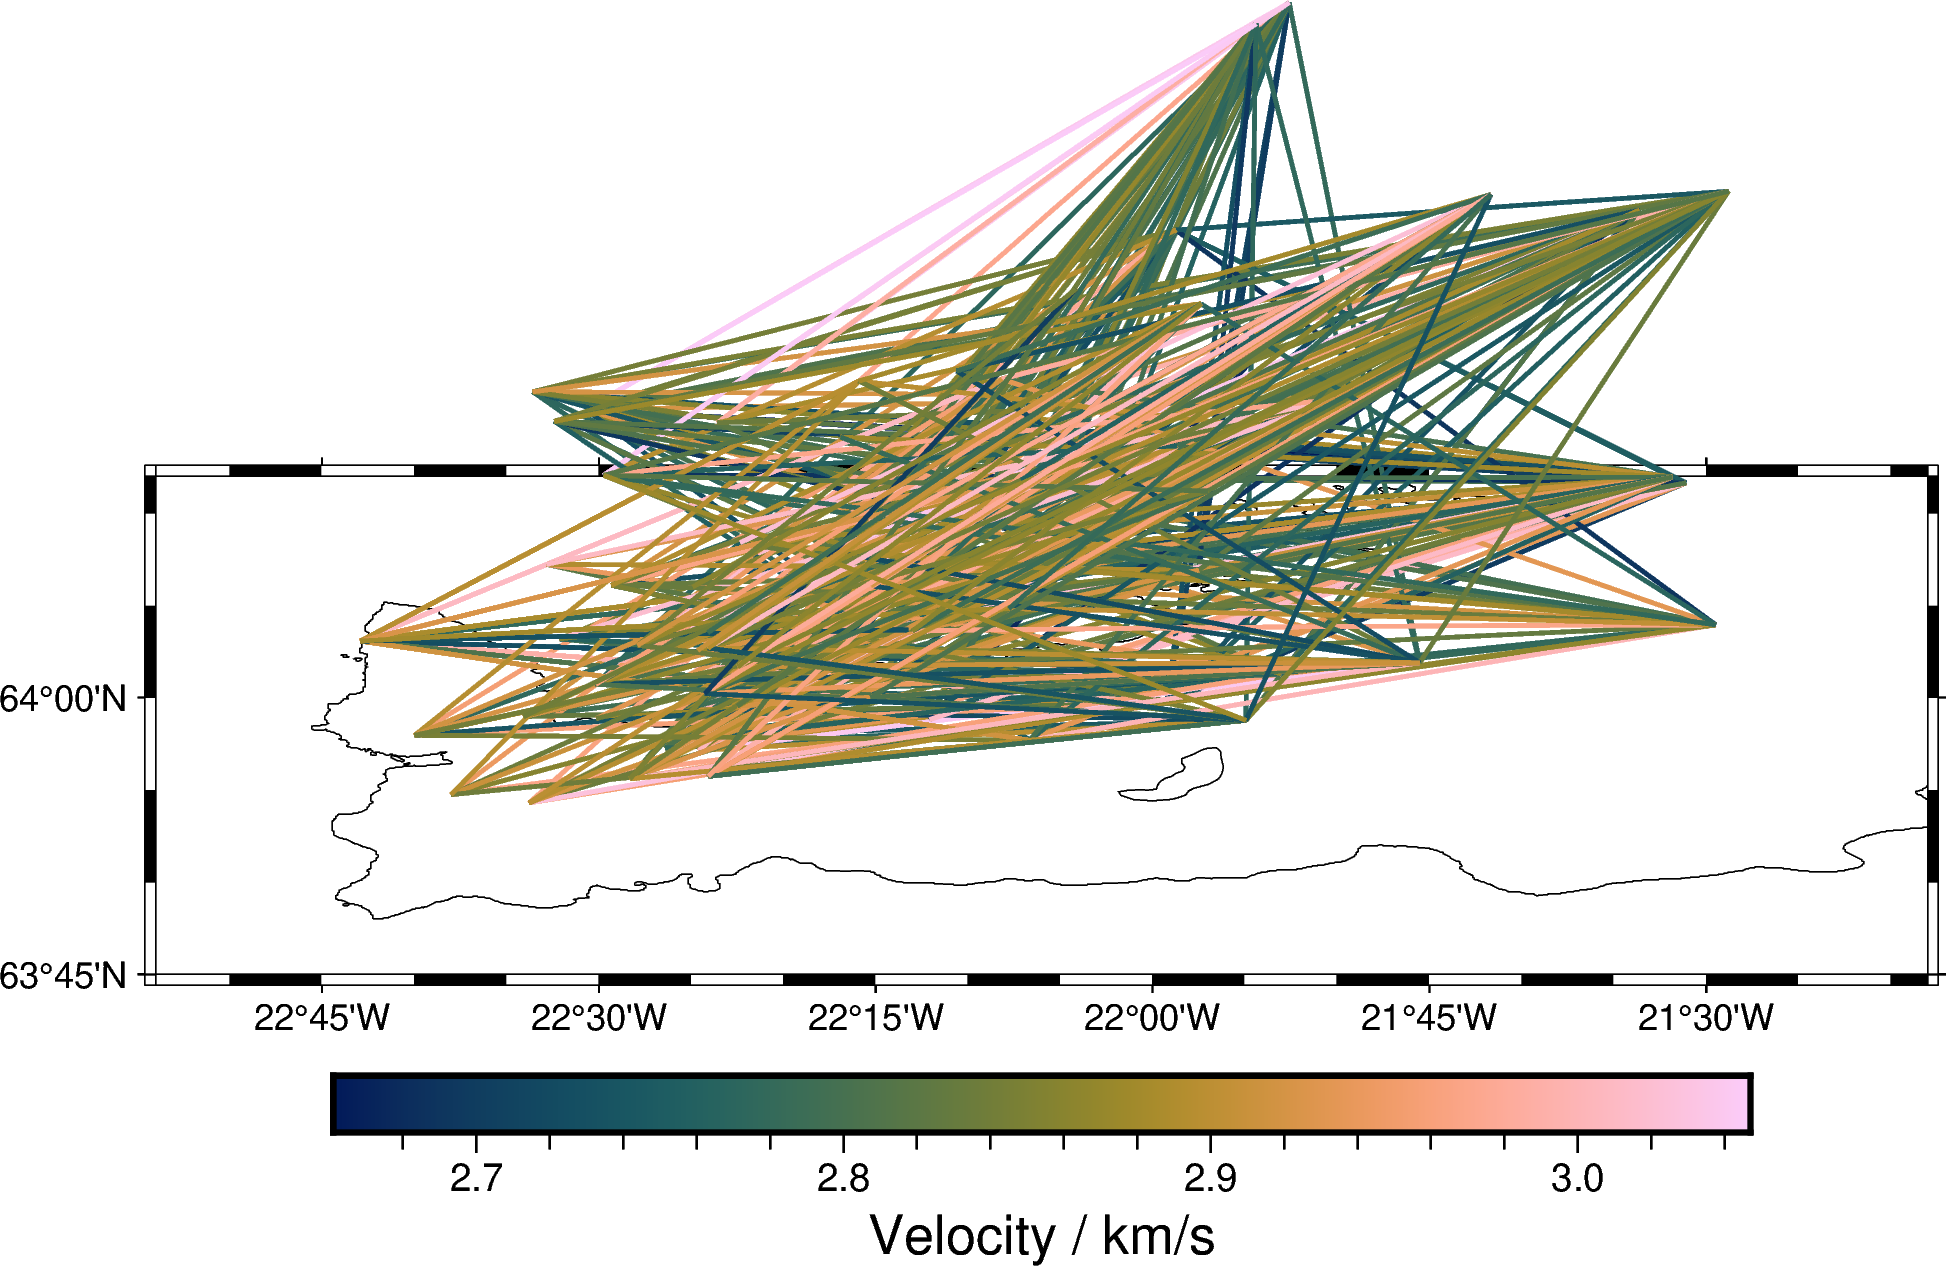

In [7]:
# print("Running for period",freq)
freq = 4.0
lat_num = 27
lon_num = 42

doggy = fmst(path="/raid2/wp280/intcc/pyFMST", templates="/raid2/wp280/intcc/pyFMST/templates")

doggy.load_velocity_pairs("/raid2/wp280/intcc/REGIONAL/auto_picks_snr_5_phase_ZZ.json", freq)
doggy.set_region(region=[64.2, 63.75, -22.9, -21.3])

doggy.load_stations('/raid2/wp280/intcc/inventory/xmlcombined/merged_response.xml')
doggy.read_station_pairs("/raid2/wp280/intcc/csvs/all_stations_pairs_20_24.csv", drop=True)

doggy.refine_station_pairs(method='std', arg=2.0)

doggy.set_background_vel(np.average(doggy.station_pairs_complete['vel'], weights=doggy.station_pairs_complete['gcm']))

doggy.config_grid(latgrid=lat_num, longrid=lon_num)
doggy.create_grid()
doggy.create_sources()

# doggy.create_otimes(unc=0.001)
# doggy.config_ttomoss(init=True, subinvss={'damping':1.0, 'smoothing':0.0})

# doggy.run_ttomoss()
# doggy.run_tslicess(True)
# doggy.load_result_grid()

# subprocess.run('covary', cwd=doggy.path)

doggy.create_otimes(unc=0.1)
doggy.config_ttomoss(init=True, subinvss={'damping':3.0, 'smoothing':3.0})

doggy.run_ttomoss()
doggy.run_tslicess(True)
doggy.load_result_grid()

doggy.plot_map(plot_stations=True, plot_rays=True)
doggy.plot_map(plot_rays_v=True, plot_tomo=False)

xyz2grd [WARNING]: 41 values gave bad indices: Pixel vs Gridline registration confusion?


(44, 29)
[[-22.93902439  64.21730769   0.3       ]
 [-22.93902439  64.2          0.3       ]
 [-22.93902439  64.18269231   0.3       ]
 ...
 [-21.26097561  63.76730777   0.3       ]
 [-21.26097561  63.75000008   0.3       ]
 [-21.26097561  63.73269239   0.3       ]]
<xarray.DataArray 'z' (y: 26, x: 41)>
array([[0.30000001, 0.30000001, 0.30000001, ..., 0.30000001, 0.30000001,
        0.30000001],
       [0.30000001, 0.30000001, 0.30000001, ..., 0.30000001, 0.30000001,
        0.30000001],
       [0.30000001, 0.30000001, 0.30000001, ..., 0.30000001, 0.30000001,
        0.30000001],
       ...,
       [0.30000001, 0.30000001, 0.30000001, ..., 0.30000001, 0.30000001,
        0.30000001],
       [0.30000001, 0.30000001, 0.30000001, ..., 0.30000001, 0.30000001,
        0.30000001],
       [0.30000001, 0.30000001, 0.30000001, ..., 0.30000001, 0.30000001,
        0.30000001]])
Coordinates:
  * y        (y) float64 63.76 63.78 63.79 63.81 ... 64.14 64.16 64.17 64.19
  * x        (x) float64 -22

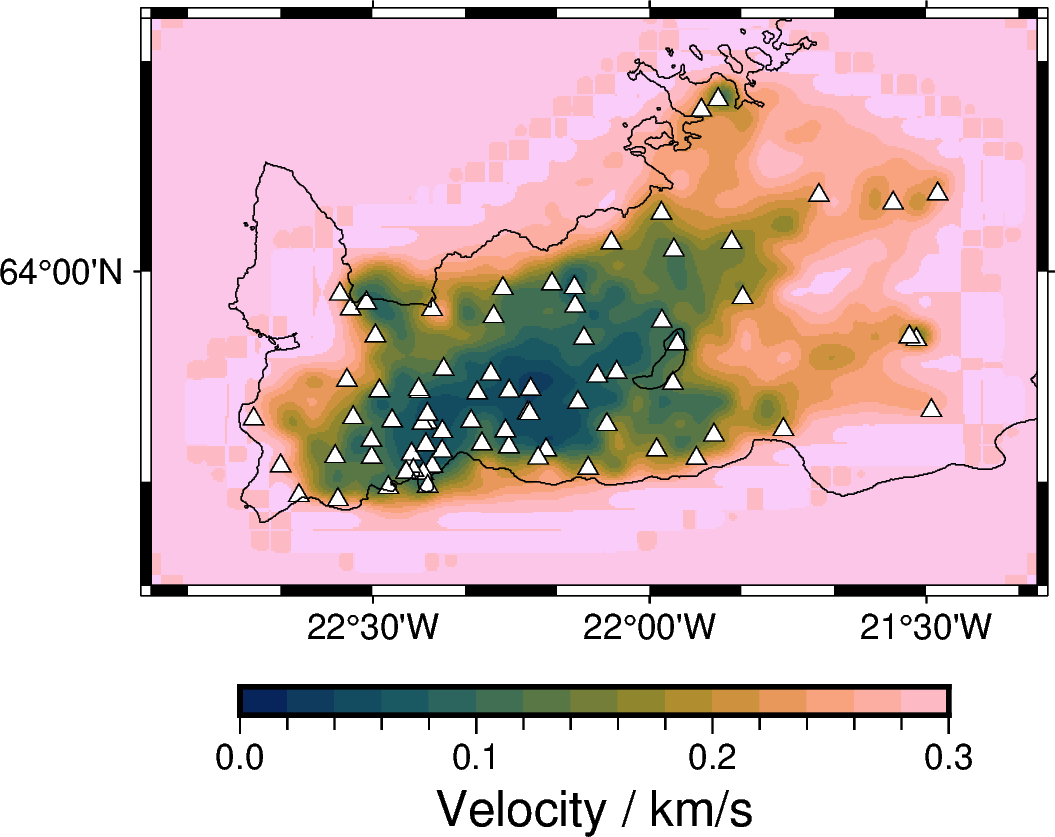

In [17]:
if os.path.exists(os.path.join(doggy.path, "covary.out")):
    with open(os.path.join(doggy.path, "covary.out"), "r") as file:
        cov = [float(line.strip()) for line in file.readlines()[1:]]
values = np.array(cov).reshape(lat_num+2, lon_num+2)

y, x = np.meshgrid(np.arange(values.shape[0]), np.arange(values.shape[1]))   
# Stack X, Y, and Z values into a single array for xyz2grd

gmt_region = [doggy.region[2], doggy.region[3], doggy.region[1], doggy.region[0]]

# Compute corresponding geographic coordinates for x and y indices
cord = [64.2, -22.9]
spacing = [1.73076894E-02,   3.90243903E-02]
# Map x and y indices to the geographic coordinates
lon = cord[1] + spacing[1] * (x-1) 
lat = cord[0] - spacing[0] * (y-1) 

print(x.shape)

# Flatten the coordinates
lon_flat = lon.flatten()
lat_flat = lat.flatten()
xyz_data = np.column_stack([lon_flat, lat_flat, values.flatten()])
print(xyz_data)

orig_grid = pygmt.xyz2grd(data=xyz_data,
                        region=gmt_region,
                        spacing=[doggy.bounds[6], doggy.bounds[7]],
                        registration="pixel")

print(orig_grid)

fig = pygmt.Figure()

min_val = 0
max_val = 0.3
increment = (max_val - min_val) / 15

# Generate the CPT with series and 10 levels
cpt = pygmt.grd2cpt(
    grid=orig_grid,
    cmap='SCM/batlow',
    reverse=False,
    series=[min_val, max_val, increment]  # [min, max, increment]
)

fig.grdimage(
    grid=orig_grid,  # Input grid
    region=gmt_region,
    projection='M7.5c',  # Mercator projection (6 inches wide)
    cmap= cpt,           
    interpolation="c",
    dpi=150
)


receivers = pd.read_csv(os.path.join(doggy.path,'gmtplot','receivers.dat'), sep="\s+", header=None)
receivers = receivers[[1, 0]] # lat and lon are wrong way around!


fig.plot(
    data=receivers,          
    region=gmt_region,                 # Map boundaries (equivalent to $bounds)
    projection='M7.5c',               # Map projection (equivalent to $proj)
    style="t0.2c",
    fill="white",
    pen="black"
)

#     if label_stations:
#         for _, station in self.stations.iterrows():  # Unpack the tuple
#             fig.text(
#                 x=station.lon,  # Use attribute access instead of dict-style indexing
#                 y=station.lat,
#                 text=station.station,
#                 pen="0.25p,black,solid",
#                 fill="white",
#                 font="10p",
#                 offset="0.5/0.5"
#             )

fig.coast(
    shorelines=True,  # Draw coastlines
    borders=[1, 2],  # Show internal administrative boundaries and countries
    resolution="f",
    frame=True
)
                    
fig.colorbar(cmap=cpt,
    frame=["x+lVelocity / km/s", "af"])

# if save_fig:
#     fig.savefig(save_fig, crop=True)
fig.savefig("covary.pdf")
fig.show()

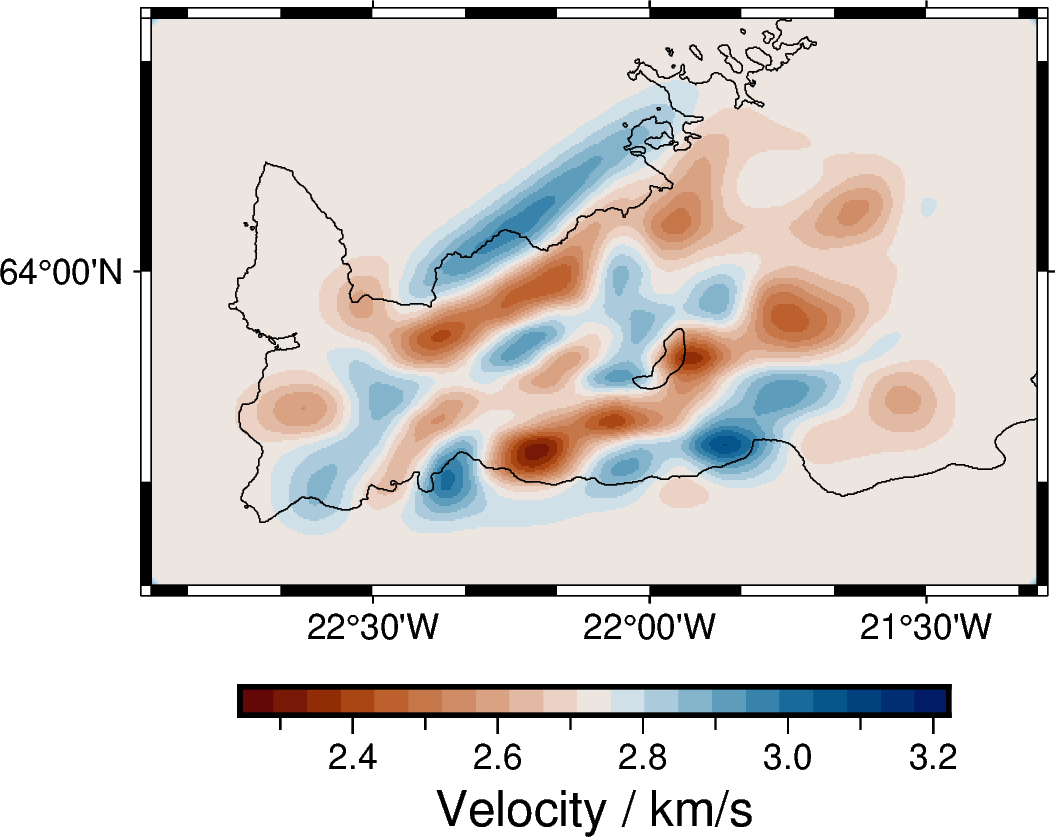

In [13]:
doggy.plot_map(nlevels = 21, projection='M7.5c', save_fig="covary_res.pdf")